# modules

In [4]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost
import catboost

# data

## raw

Dataset Source: [Link](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition)

In [94]:
df_raw = pd.read_csv('../data/raw/ObesityDataSet_raw_and_data_sinthetic.csv')

In [95]:
df_raw.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [96]:
df_raw.replace({
    'yes': 'Yes',
    'no': 'No'
}, inplace=True)

In [97]:
binary_columns = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for col in binary_columns:
    df_raw[col].replace({
        'Yes': True,
        'No': False
    }, inplace=True)

/tmp/ipykernel_168030/3652403840.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_raw[col].replace({
/tmp/ipykernel_168030/3652403840.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_raw[col].replace({


In [98]:
df_raw.rename(columns={
    'Gender': 'Is_Male'
}, inplace=True)

df_raw['Is_Male'] = df_raw['Is_Male'].apply(lambda x: x == 'Male')

In [99]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Is_Male                         2111 non-null   bool   
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   bool   
 5   FAVC                            2111 non-null   bool   
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   bool   
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   bool   
 12  FAF                             21

In [100]:
df_raw.rename(columns={
    'family_history_with_overweight': 'Familial_Overweight_History',
    'FAVC': 'High_Caloric_Food',
    'FCVC': 'Vegetables_In_Meals',
    'NCP': 'Daily_Main_Meals',
    'CAEC': 'Eat_Between_Meals',
    'SMOKE': 'Smoking',
    'CH2O': 'Water_Consumption',
    'SCC': 'Calories_Monitoring',
    'FAF': 'Physical_Activity',
    'TUE': 'Screen_Time',
    'CALC': 'Alcohol_Consumption',
    'MTRANS': 'Transportation',
    'NObeyesdad': 'Obesity_Level'
}, inplace=True)

In [101]:
df_raw.to_csv("../data/processed/dataset.csv", index=False)

## dataset

### load

In [102]:
# local
df = pd.read_csv('../data/processed/dataset.csv')

In [8]:
# colab
df = pd.read_csv('obesity_level.csv')

### explore

In [103]:
df.columns

Index(['Is_Male', 'Age', 'Height', 'Weight', 'Familial_Overweight_History',
       'High_Caloric_Food', 'Vegetables_In_Meals', 'Daily_Main_Meals',
       'Eat_Between_Meals', 'Smoking', 'Water_Consumption',
       'Calories_Monitoring', 'Physical_Activity', 'Screen_Time',
       'Alcohol_Consumption', 'Transportation', 'Obesity_Level'],
      dtype='object')

In [106]:
df.head()

,Is_Male,Age,Height,Weight,Familial_Overweight_History,High_Caloric_Food,Vegetables_In_Meals,Daily_Main_Meals,Eat_Between_Meals,Smoking,Water_Consumption,Calories_Monitoring,Physical_Activity,Screen_Time,Alcohol_Consumption,Transportation,Obesity_Level
0,False,21.0,1.62,64.0,True,False,2.0,3.0,Sometimes,False,2.0,False,0.0,1.0,No,Public_Transportation,Normal_Weight
1,False,21.0,1.52,56.0,True,False,3.0,3.0,Sometimes,True,3.0,True,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,True,23.0,1.80,77.0,True,False,2.0,3.0,Sometimes,False,2.0,False,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,True,27.0,1.80,87.0,False,False,3.0,3.0,Sometimes,False,2.0,False,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,True,22.0,1.78,89.8,False,False,2.0,1.0,Sometimes,False,2.0,False,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [107]:
for col in [c for c in df.columns if df[c].dtype in ['object', 'bool']]:
    print(df[col].value_counts())
    print()

Is_Male
True     1068
False    1043
Name: count, dtype: int64

Familial_Overweight_History
True     1726
False     385
Name: count, dtype: int64

High_Caloric_Food
True     1866
False     245
Name: count, dtype: int64

Eat_Between_Meals
Sometimes     1765
Frequently     242
Always          53
No              51
Name: count, dtype: int64

Smoking
False    2067
True       44
Name: count, dtype: int64

Calories_Monitoring
False    2015
True       96
Name: count, dtype: int64

Alcohol_Consumption
Sometimes     1401
No             639
Frequently      70
Always           1
Name: count, dtype: int64

Transportation
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64

Obesity_Level
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name

The BMI order is:
- Insufficient Weight (Underweight)
- Normal Weight
- Overweight Level I
- Overweight Level II
- Obesity Type I
- Obesity Type II
- Obesity Type III (Severe/Morbid Obesity)

In [57]:
df.describe()

,Age,Height,Weight,Vegetables_In_Meals,Daily_Main_Meals,Water_Consumption,Physical_Activity,Screen_Time
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


- the dataset seems clean in terms of numerical range of values
- we have few outliers like the only one drinking alcohol always and the 7 bike riders

### preprocess

In [108]:
boolean_features = [col for col in df.columns if df[col].dtype == 'bool']

for col in boolean_features:
    df[col] = df[col].astype(int)

In [109]:
df["BMI"] = (df["Weight"] / (df["Height"]) ** 2)
df['BMI'] = df['BMI'].apply(lambda x: float("{:.2f}".format(x)))

In [112]:
columns = [col for col in df.columns if col != "Obesity_Level"] + ["Obesity_Level"]
df = df.reindex(columns=columns)

In [114]:
df

,Is_Male,Age,Height,Weight,Familial_Overweight_History,High_Caloric_Food,Vegetables_In_Meals,Daily_Main_Meals,Eat_Between_Meals,Smoking,Water_Consumption,Calories_Monitoring,Physical_Activity,Screen_Time,Alcohol_Consumption,Transportation,BMI,Obesity_Level
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,0.000000,1.000000,No,Public_Transportation,24.39,Normal_Weight
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,Sometimes,1,3.000000,1,3.000000,0.000000,Sometimes,Public_Transportation,24.24,Normal_Weight
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,2.000000,1.000000,Frequently,Public_Transportation,23.77,Normal_Weight
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,Sometimes,0,2.000000,0,2.000000,0.000000,Frequently,Walking,26.85,Overweight_Level_I
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,Sometimes,0,2.000000,0,0.000000,0.000000,Sometimes,Public_Transportation,28.34,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,Sometimes,0,1.728139,0,1.676269,0.906247,Sometimes,Public_Transportation,44.90,Obesity_Type_III
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,Sometimes,0,2.005130,0,1.341390,0.599270,Sometimes,Public_Transportation,43.74,Obesity_Type_III
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,Sometimes,0,2.054193,0,1.414209,0.646288,Sometimes,Public_Transportation,43.54,Obesity_Type_III
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,Sometimes,0,2.852339,0,1.139107,0.586035,Sometimes,Public_Transportation,44.07,Obesity_Type_III


In [88]:
df.to_csv("../data/processed/dataset.csv", index=False)

### analyze

In [82]:
df['Obesity_Level_Numerical'] = df['Obesity_Level'].map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
})

In [83]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Obesity_Level_Numerical')
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()
categorical_features.remove('Obesity_Level')
target = ['Obesity_Level']
target_num = ['Obesity_Level_Numerical']

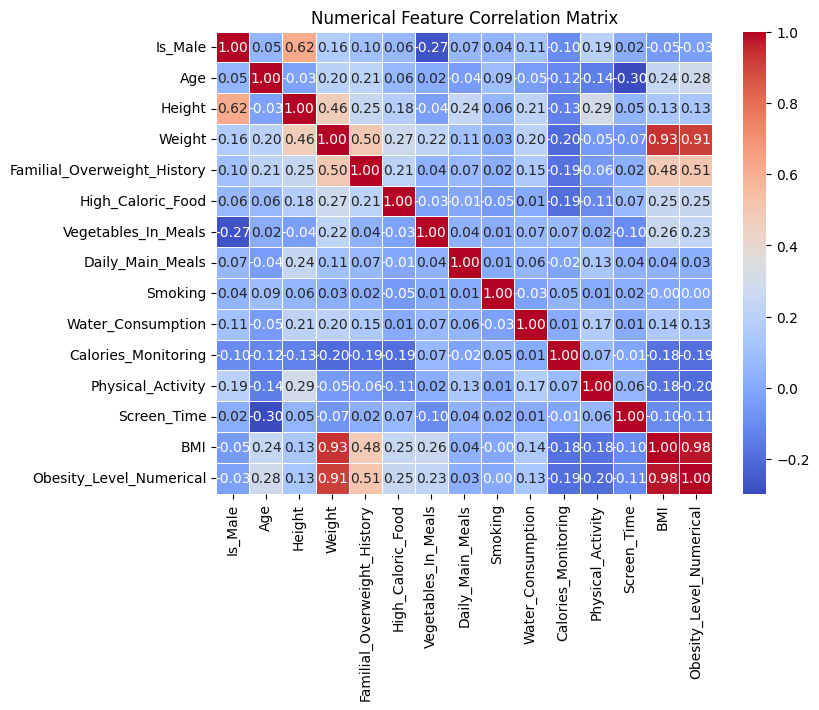

In [84]:
numerical_corr = df[numerical_features + target_num].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Numerical Feature Correlation Matrix")
plt.show()

In [85]:
df_encoded = pd.get_dummies(df[categorical_features])

X_encoded = pd.concat([df[numerical_features], df_encoded], axis=1)
mi_scores = mutual_info_classif(X_encoded, df['Obesity_Level'])

mi_results = pd.DataFrame({'Feature': X_encoded.columns, 'MI Score': mi_scores}).sort_values(by='MI Score', ascending=False)

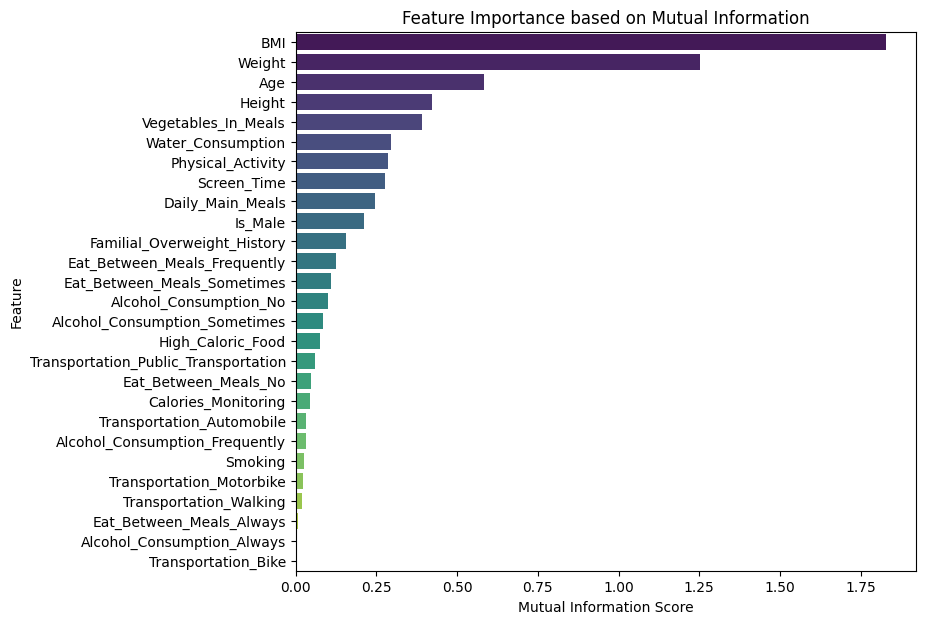

In [86]:
plt.figure(figsize=(8, 7))
sns.barplot(x=mi_results['MI Score'], y=mi_results['Feature'], palette="viridis", hue=mi_results['Feature'])
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Feature Importance based on Mutual Information")
plt.show()

### features & target

In [117]:
df['Obesity_Level'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [118]:
df['Obesity_Level'] = df['Obesity_Level'].map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
})

In [120]:
df = pd.get_dummies(df)

In [122]:
boolean_features = [col for col in df.columns if df[col].dtype == 'bool']

for col in boolean_features:
    df[col] = df[col].astype(int)

In [125]:
columns = [col for col in df.columns if col != "Obesity_Level"] + ["Obesity_Level"]
df = df.reindex(columns=columns)

df.columns

Index(['Is_Male', 'Age', 'Height', 'Weight', 'Familial_Overweight_History',
       'High_Caloric_Food', 'Vegetables_In_Meals', 'Daily_Main_Meals',
       'Smoking', 'Water_Consumption', 'Calories_Monitoring',
       'Physical_Activity', 'Screen_Time', 'BMI', 'Eat_Between_Meals_Always',
       'Eat_Between_Meals_Frequently', 'Eat_Between_Meals_No',
       'Eat_Between_Meals_Sometimes', 'Alcohol_Consumption_Always',
       'Alcohol_Consumption_Frequently', 'Alcohol_Consumption_No',
       'Alcohol_Consumption_Sometimes', 'Transportation_Automobile',
       'Transportation_Bike', 'Transportation_Motorbike',
       'Transportation_Public_Transportation', 'Transportation_Walking',
       'Obesity_Level'],
      dtype='object')

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Is_Male                               2111 non-null   int64  
 1   Age                                   2111 non-null   float64
 2   Height                                2111 non-null   float64
 3   Weight                                2111 non-null   float64
 4   Familial_Overweight_History           2111 non-null   int64  
 5   High_Caloric_Food                     2111 non-null   int64  
 6   Vegetables_In_Meals                   2111 non-null   float64
 7   Daily_Main_Meals                      2111 non-null   float64
 8   Smoking                               2111 non-null   int64  
 9   Water_Consumption                     2111 non-null   float64
 10  Calories_Monitoring                   2111 non-null   int64  
 11  Physical_Activity

In [127]:
X = df.drop(columns=['Obesity_Level'])
# X = pd.get_dummies(X)

# encoder = LabelEncoder()
# y = encoder.fit_transform(df['Obesity_Level'])
y = df['Obesity_Level']

In [129]:
df.to_csv("../data/processed/dataset.csv", index=False)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Is_Male                               2111 non-null   int64  
 1   Age                                   2111 non-null   float64
 2   Height                                2111 non-null   float64
 3   Weight                                2111 non-null   float64
 4   Familial_Overweight_History           2111 non-null   int64  
 5   High_Caloric_Food                     2111 non-null   int64  
 6   Vegetables_In_Meals                   2111 non-null   float64
 7   Daily_Main_Meals                      2111 non-null   float64
 8   Smoking                               2111 non-null   int64  
 9   Water_Consumption                     2111 non-null   float64
 10  Calories_Monitoring                   2111 non-null   int64  
 11  Physical_Activity

# modeling

In [128]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgboost.XGBClassifier(eval_metric='mlogloss'),
    "CatBoost": catboost.CatBoostClassifier(verbose=0)
}

# Inverted Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    scores = []
    for train_index, test_index in kf.split(X):
        # nversion happens here, train, test = test, train
        X_train, X_test = X.iloc[test_index], X.iloc[train_index]
        y_train, y_test = y[test_index], y[train_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    results.append((name, np.mean(scores)))

results_df = pd.DataFrame(results, columns=["Classifier", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
results_df

,Classifier,Accuracy
1,Random Forest,0.974065
3,CatBoost,0.972998
2,XGBoost,0.959379
0,Decision Tree,0.955236


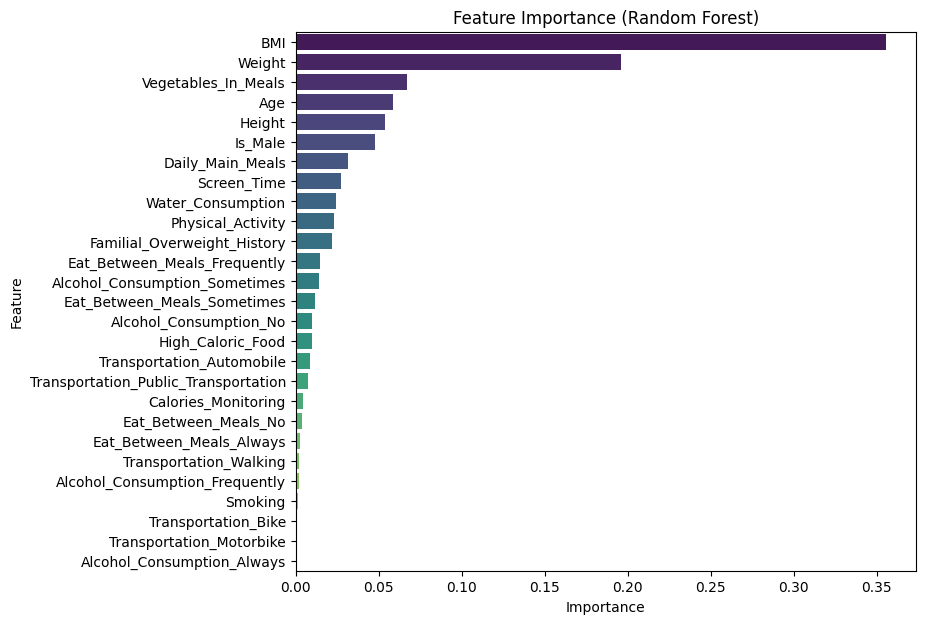

In [74]:
model = RandomForestClassifier()
model.fit(X, y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 7))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances, palette="viridis")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.show()

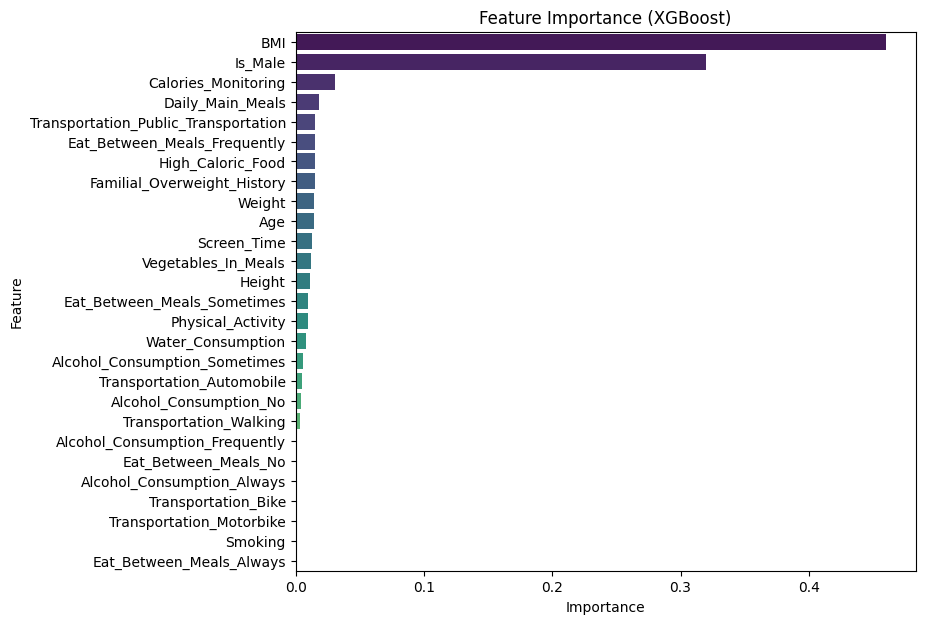

In [75]:
model = xgboost.XGBClassifier()
model.fit(X, y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 7))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances, palette="viridis")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.show()

- for Random Forest we can use SMILE
- for xgboost we can use XGBoost4J